In [2]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix

from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
path = "images-photographes"

In [4]:
def load_dataset(dir_sc, images_per_class=None):
    inames = []
    ilabels = []
    cnames = sorted(os.listdir(dir_sc))
    for ilabel, cl in enumerate(cnames):
        dir_cl = os.path.join(dir_sc, cl)
        for iname in os.listdir(dir_cl)[:images_per_class]:
            inames.append(os.path.join(cl, iname))
            ilabels.append(ilabel)
    ilabels = np.array(ilabels)
    return inames, ilabels, cnames


In [5]:
inames, ilabels, class_names = load_dataset(path)

In [5]:
class_names

['daido-moriyama',
 'dorothea-lange',
 'felix-nadar',
 'henri-cartier-bresson',
 'irving-penn',
 'malik-sidibe',
 'marc-riboud',
 'seidou-keita',
 'shomei-tomatsu',
 'walter-evans']

In [6]:
ilabels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

# SIFTs COMPUTATION

In [7]:
def dense_sampling(im, s=8):
    w, h = im.shape
    x = np.arange(0, w, s)
    y = np.arange(0, h, s)
    return x, y

In [8]:
def conv_separable(im, h_x, h_y, pad=1):
    h_x = h_x.reshape(1,3)
    h_y = h_y.reshape(3,1)

    im_w, im_h = im.shape
    hx_w, hx_h = h_x.shape
    hy_w, hy_h = h_y.shape

    h_x_t = h_x.transpose()
    h_y_t = h_y.transpose()

    if hx_w != 1:
        raise ValueError()
    if hx_h % 2 != 1:
        raise ValueError()
    if hy_h != 1:
        raise ValueError()
    if hy_w % 2 != 1:
        raise ValueError()
    if hx_h != hy_w:
        raise ValueError()


In [9]:
def auto_padding(im, k=16, s=8):
    w, h = im.shape
    x = np.arange(0, w, s)
    y = np.arange(0, h, s)
    # last region could be smaller
    last_r = im[x[-1]:x[-1]+k, y[-1]:y[-1]+k]
    if last_r.shape == (k, k):
        return im
    dif_w = k - last_r.shape[0]
    dif_h = k - last_r.shape[1]
    n_im = np.zeros((w+dif_w, h+dif_h))
    id_w = dif_w // 2
    id_h = dif_h // 2
    n_im[id_w:id_w+w, id_h:id_h+h] = im
    return n_im

In [10]:
def gaussian_mask(size=16, sigma=0.5):
    sigma *= size
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

In [11]:
def compute_grad(I):

    ha = 1/4 * np.array([1,2,1])
    hb = 1/2 * np.array([1,0,-1])

    Ix = conv_separable(I, hb, ha)
    Iy = conv_separable(I, ha, hb)
    print(Ix)
    print(Iy)
    return Ix, Iy

In [12]:
def compute_grad(I):

    gX = cv.Sobel(I, ddepth=cv.CV_32F, dx=1, dy=0, ksize=3)
    gY = cv.Sobel(I, ddepth=cv.CV_32F, dx=0, dy=1, ksize=3)
    #print(gX)
    #print(gY)
    return gX, gY

In [13]:
def compute_grad_ori(g_x, g_y, g_m, b=8):
    ori = np.zeros((b, 2))
    for i in range(b):
        ori[i,0] = np.cos(2 * np.pi * i / b)
        ori[i,1] = np.sin(2 * np.pi * i / b)
    w, h = g_m.shape
    # TODO: algebraic form
    g_o = np.zeros((w, h))
    for i in range(w):
        for j in range(h):
            if g_m[i,j] > 0:
                v = np.array([g_y[i,j], -g_x[i,j]])
                v = v / np.linalg.norm(v, ord=2)
                prod = np.dot(ori,v)
                g_o[i,j] = np.argmax(prod)
            else:
                g_o[i,j] = -1
    g_o = g_o.astype(int)
    return g_o

In [14]:
def compute_grad_mod_ori(I):


    Ix, Iy = compute_grad(I)

    Gn = np.sqrt(Ix**2 + Iy**2)
    Go = compute_grad_ori(Ix, Iy, Gn, 8)#np.arctan(Iy/Ix)
    return Gn, Go

In [15]:
def compute_histogram(g_n, g_o):
    """
    g_n and g_o are 4x4 matrices that contain the norm, and the discretized orientation.
    Warning: g_o can contain -1, thos1e values should be discarded.
    """
    hist = np.zeros((8))
    for i in range(8):
        hist[i] = g_n[g_o == i].sum()
    return hist

In [16]:
def compute_sift_region(Gn, Go, mask=None):
    t_min=.5
    t_max=.2
    with_l2 = True

    patch_size = 16
    sift = np.zeros((128)) 

    if mask is not None:
        Gn = Gn * mask
    
    idx = 0
    for k in range(0, patch_size, 4):
        for l in range(0, patch_size, 4):
            hist = compute_histogram(Gn[l:l+4,k:k+4], Go[l:l+4,k:k+4])            
            sift[idx:idx+8] = hist
            idx += 8

    norm = np.linalg.norm(sift, ord=2)
    # min thresholding on norm
    if norm <= t_min:
        return np.zeros((128))
    # l2-normalization
    if with_l2:
        sift = sift / norm
    # max thresholding on values
    sift[sift >= t_max] = t_max
    # l2-normalization
    if with_l2:
        norm = np.linalg.norm(sift, ord=2)
        sift = sift / norm
    return sift

In [19]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    m = gaussian_mask()
    
    # Here, compute on the global image (norm, gradients)
    Gn, Go = compute_grad_mod_ori(I)
    
    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            if xi + 16 <= Gn.shape[0] and yj + 16 <= Gn.shape[1]:  # it was usefull afterall
                sifts[i, j, :] = compute_sift_region(Gn[xi:xi+16, yj:yj+16], Go[xi:xi+16, yj:yj+16], m) # TODO SIFT du patch de coordonnee (xi, yj)
    return sifts

In [20]:
from numpy import asarray
from numpy import savez_compressed

In [21]:
def ComputeSiftDataset(inames):

    descriptors = []
    for x in inames:
        p = os.path.join(path, x)
        print(p)
        img = cv.imread(p)
        gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        #print(gray.shape)
        des = compute_sift_image(gray)
        des = (des * 255).astype('uint8')
        descriptors.append(des)
    
    return descriptors

In [22]:
descriptors = ComputeSiftDataset(inames)

images-photographes\daido-moriyama\16_daido_moriyama_24.jpg
images-photographes\daido-moriyama\16_daido_moriyama_25.jpg
images-photographes\daido-moriyama\16_daido_moriyama_26.jpg
images-photographes\daido-moriyama\16_daido_moriyama_27.jpg
images-photographes\daido-moriyama\21_moriyama_mep_050.jpg
images-photographes\daido-moriyama\21_moriyama_mep_051.jpg
images-photographes\daido-moriyama\21_moriyama_mep_059.jpg
images-photographes\daido-moriyama\21_moriyama_mep_063.jpg
images-photographes\daido-moriyama\21_moriyama_mep_064.jpg
images-photographes\daido-moriyama\21_moriyama_mep_065.jpg
images-photographes\daido-moriyama\21_moriyama_mep_066.jpg
images-photographes\daido-moriyama\21_moriyama_mep_068.jpg
images-photographes\daido-moriyama\21_moriyama_mep_073.jpg
images-photographes\daido-moriyama\21_moriyama_mep_075.jpg
images-photographes\daido-moriyama\21_moriyama_mep_077.jpg
images-photographes\daido-moriyama\21_moriyama_mep_078.jpg
images-photographes\daido-moriyama\21_moriyama_mep_0

images-photographes\irving-penn\17_irving_penn_19.jpg
images-photographes\irving-penn\17_irving_penn_21.jpg
images-photographes\irving-penn\17_irving_penn_23.jpg
images-photographes\irving-penn\17_irving_penn_29.jpg
images-photographes\irving-penn\17_irving_penn_31.jpg
images-photographes\irving-penn\17_irving_penn_33.jpg
images-photographes\irving-penn\17_irving_penn_35.jpg
images-photographes\irving-penn\17_irving_penn_39.jpg
images-photographes\irving-penn\17_irving_penn_41.jpg
images-photographes\irving-penn\17_irving_penn_43.jpg
images-photographes\irving-penn\17_irving_penn_45.jpg
images-photographes\irving-penn\17_irving_penn_47.jpg
images-photographes\irving-penn\17_irving_penn_49.jpg
images-photographes\irving-penn\17_irving_penn_51.jpg
images-photographes\irving-penn\17_irving_penn_53.jpg
images-photographes\irving-penn\17_irving_penn_55.jpg
images-photographes\irving-penn\17_irving_penn_57.jpg
images-photographes\irving-penn\17_irving_penn_59.jpg
images-photographes\irving-p

In [ ]:
descriptors

In [23]:
len(descriptors)

280

In [24]:
descriptors[0]

array([[[ 0,  0,  0, ...,  0,  4,  0],
        [ 0,  0,  0, ...,  4,  4,  3],
        [ 2,  2,  0, ..., 15, 43,  8],
        ...,
        [ 5, 14, 19, ..., 16,  9, 23],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[ 3,  0,  0, ...,  0,  6,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  6, 25, ...,  3,  0,  4],
        ...,
        [17, 23, 52, ...,  0,  6, 29],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[ 0,  0,  0, ...,  0,  4,  0],
        [ 0,  0,  0, ...,  0,  0,  5],
        [37,  2,  0, ..., 28,  5, 17],
        ...,
        [ 6, 15, 22, ..., 19,  0, 11],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       ...,

       [[ 1,  0,  0, ...,  0,  0,  0],
        [31, 27,  6, ...,  0,  0,  0],
        [ 0, 74, 31, ...,  3,  0,  0],
        ...,
        [ 1,  9,  0, ..., 26, 20,  3],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0

In [25]:
descriptors[0].shape

(425, 319, 128)

In [26]:
data = np.array(descriptors)
savez_compressed('SIFTS DATA.npz', data) 

C:\Users\94\AppData\Local\Temp/ipykernel_17988/1971281243.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(descriptors)


In [27]:
data = np.load('siftsV2.npz')
data = np.array(data)


FileNotFoundError: [Errno 2] No such file or directory: 'siftsV2.npz'

In [ ]:
print(data[0].shape)

In [ ]:
data[0]

In [30]:
for d in descriptors:
    print(d.shape)

(425, 319, 128)
(401, 301, 128)
(377, 283, 128)
(387, 291, 128)
(225, 151, 128)
(151, 225, 128)
(146, 225, 128)
(225, 158, 128)
(225, 151, 128)
(225, 150, 128)
(170, 225, 128)
(225, 169, 128)
(225, 146, 128)
(225, 144, 128)
(152, 225, 128)
(151, 225, 128)
(151, 225, 128)
(149, 225, 128)
(150, 225, 128)
(75, 50, 128)
(225, 152, 128)
(225, 152, 128)
(156, 225, 128)
(161, 225, 128)
(52, 75, 128)
(225, 153, 128)
(144, 225, 128)
(149, 225, 128)
(150, 225, 128)
(153, 225, 128)
(225, 154, 128)
(225, 185, 128)
(225, 180, 128)
(180, 225, 128)
(174, 225, 128)
(166, 225, 128)
(220, 225, 128)
(225, 160, 128)
(171, 225, 128)
(225, 222, 128)
(171, 225, 128)
(225, 176, 128)
(225, 225, 128)
(225, 214, 128)
(172, 225, 128)
(225, 174, 128)
(225, 174, 128)
(220, 225, 128)
(225, 222, 128)
(225, 209, 128)
(225, 175, 128)
(225, 162, 128)
(225, 179, 128)
(225, 196, 128)
(187, 225, 128)
(225, 138, 128)
(225, 183, 128)
(225, 175, 128)
(225, 167, 128)
(225, 162, 128)
(225, 180, 128)
(225, 167, 128)
(174, 225, 1

In [29]:
data = np.load('SIFTS DATA.npz')
data = np.array(data)

print(data)

['arr_0']


In [30]:
from sklearn.cluster import KMeans

In [31]:
def compute_split(length, seed=1337, pc=0.80):
    train_ids = np.random.RandomState(seed=seed).choice(
        length,
        size=int(length * pc),
        replace=False)
    test_ids = np.array(list(set(np.arange(length)) - set(train_ids)))
    return train_ids, test_ids

In [32]:
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]

    zeros_vect = np.zeros((128))
    kmeans = KMeans(n_clusters=n_clusters).fit(sift)
    centers = kmeans.cluster_centers_
    np.append(centers, zeros_vect)
    vdict = centers

    return vdict

In [33]:
vdict = compute_visual_dict(descriptors)
vdict

array([[ 9.85165563, 13.62119205, 14.80264901, ...,  3.04238411,
         2.73245033,  2.9615894 ],
       [ 4.55443548,  3.03024194,  3.38709677, ...,  6.29637097,
         6.29032258,  6.22177419],
       [16.06855277, 14.21762786, 13.34494015, ..., 10.7312296 ,
        10.03155604,  9.93035909],
       ...,
       [10.8915537 , 11.12408759, 11.24087591, ..., 12.58394161,
        11.89051095, 13.33159541],
       [11.49033816, 10.01932367, 11.43236715, ..., 11.99516908,
         8.28381643,  8.22222222],
       [ 0.71583514,  0.47071584,  0.4186551 , ..., 20.84815618,
         9.42950108,  2.5032538 ]])

In [34]:
vdict.shape

(1000, 128)

In [35]:
def display_images(images):
    n_images,w,h = images.shape
    n = int(np.ceil(np.sqrt(n_images)))
    im = np.zeros((n*w, n*h))
    for k in range(n_images):
        i = k % n
        j = k // n
        im[i*w:i*w+w, j*h:j*h+h] = images[k]

    plt.figure(figsize=(0.7*n,0.7*n))
    plt.gray()
    plt.imshow(im)
    plt.axis('off')
    plt.show()

In [36]:
def dense_sampling(im, s=8):
    w, h = im.shape
    x = np.arange(0, w, s)
    y = np.arange(0, h, s)
    return x, y

In [37]:
def auto_padding(im, k=16, s=8):
    w, h = im.shape
    x = np.arange(0, w, s)
    y = np.arange(0, h, s)
    # last region could be smaller
    last_r = im[x[-1]:x[-1]+k, y[-1]:y[-1]+k]
    if last_r.shape == (k, k):
        return im
    dif_w = k - last_r.shape[0]
    dif_h = k - last_r.shape[1]
    n_im = np.zeros((w+dif_w, h+dif_h))
    id_w = dif_w // 2
    id_h = dif_h // 2
    n_im[id_w:id_w+w, id_h:id_h+h] = im
    return n_im

In [38]:
def compute_regions(im, k=16, s=8):
    x, y = dense_sampling(im) # before padding
    im = auto_padding(im)
    images = np.zeros((x.shape[0], y.shape[0], k, k))
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            images[i,j] = im[x[i]:x[i]+k, y[j]:y[j]+k]
    return images

In [39]:
def get_regions(inames):
    vdpaths = [os.path.join(path, iname) for iname in inames]

    regions = []
    for p in vdpaths:
        im = cv.imread(p)
        gray= cv.cvtColor(im,cv.COLOR_BGR2GRAY)
        regions.append(compute_regions(gray))

    k = regions[0].shape[-1]
    n_reg = np.array([r.shape[0]*r.shape[1] for r in regions])
    cs_reg = np.cumsum(n_reg)

    regions = [r.reshape(-1, k, k) for r in regions]
    regions = np.concatenate(regions, axis=0)

    return regions

In [40]:
indexes = np.random.randint(0, len(inames), 30)
sifts = [descriptors[i] for i in indexes]
chosen_inames = [inames[i] for i in indexes]

In [41]:
sifts_chosen = ComputeSiftDataset(chosen_inames)

images-photographes\irving-penn\17_irving_penn_57.jpg
images-photographes\daido-moriyama\21_moriyama_mep_051.jpg
images-photographes\malik-sidibe\18_sidibe_41.jpg
images-photographes\daido-moriyama\16_daido_moriyama_27.jpg
images-photographes\irving-penn\17_irving_penn_96.jpg
images-photographes\henri-cartier-bresson\21-cartier-bresson_025_bnf_42.jpg
images-photographes\irving-penn\17_irving_penn_61.jpg
images-photographes\henri-cartier-bresson\21-cartier-bresson_151_bnf_2.jpg
images-photographes\daido-moriyama\21_moriyama_mep_094.jpg
images-photographes\henri-cartier-bresson\21-cartier-bresson_285_bnf_109.jpg
images-photographes\dorothea-lange\18_lange_jeu-de-paume_46.jpg
images-photographes\marc-riboud\21_riboud_guimet_18.jpg
images-photographes\daido-moriyama\21_moriyama_mep_081.jpg
images-photographes\marc-riboud\21_riboud_guimet_52.jpg
images-photographes\irving-penn\17_irving_penn_90.jpg
images-photographes\malik-sidibe\18_sidibe_20.jpg
images-photographes\irving-penn\17_irving_p

In [42]:
regions = get_regions(chosen_inames)

In [43]:
sift = [s.reshape(-1, sifts_chosen[0].shape[-1]) for s in sifts_chosen]
sift = np.concatenate(sift, axis=0)

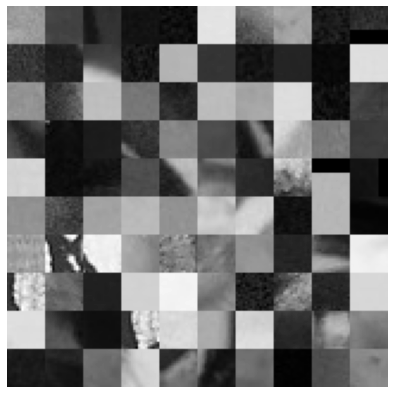

In [44]:
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

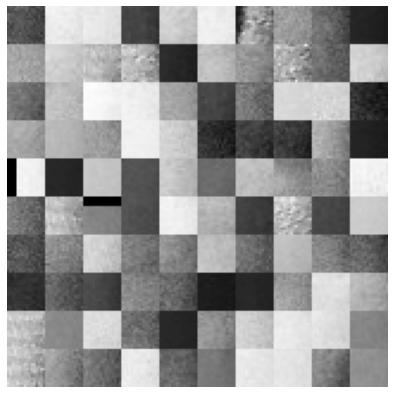

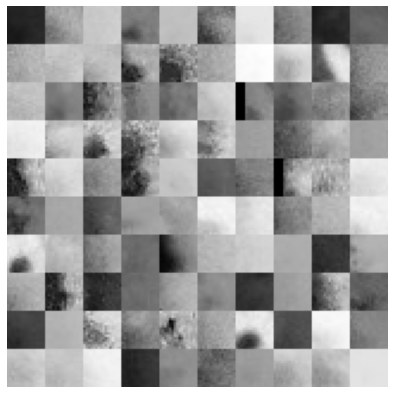

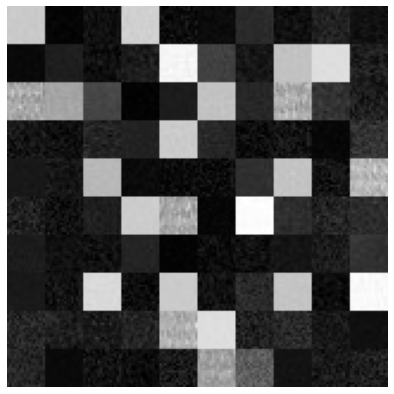

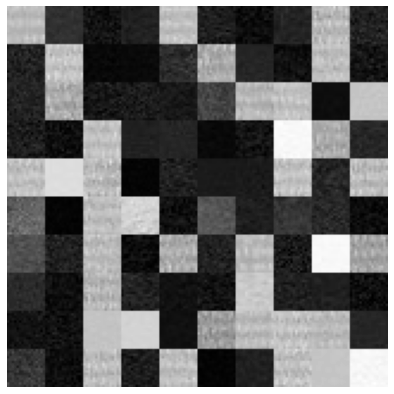

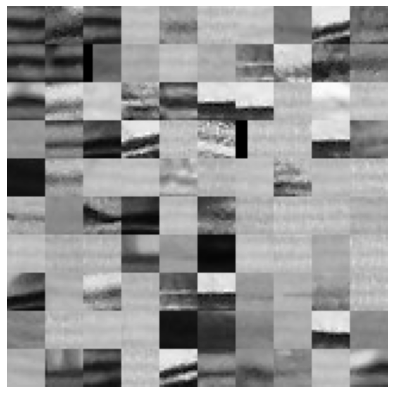

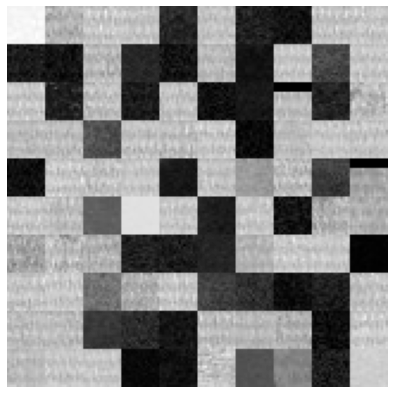

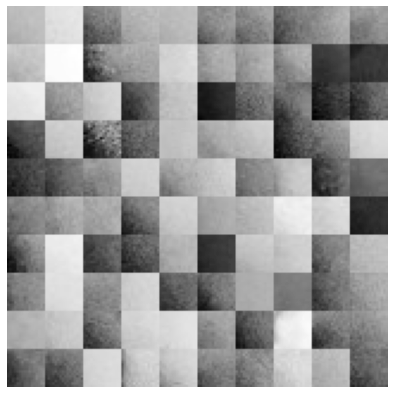

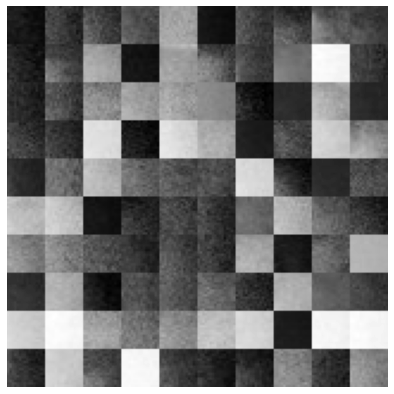

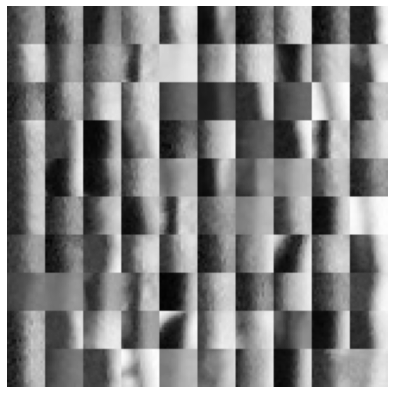

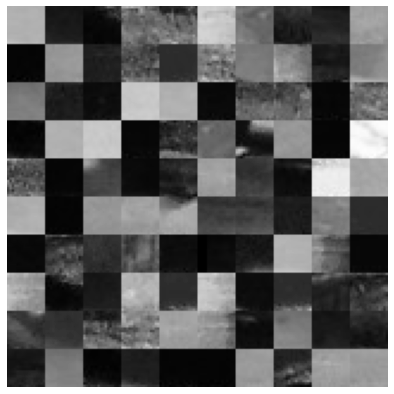

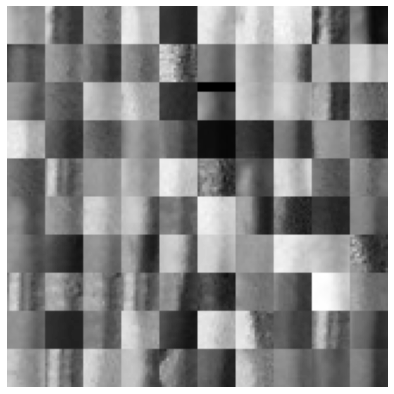

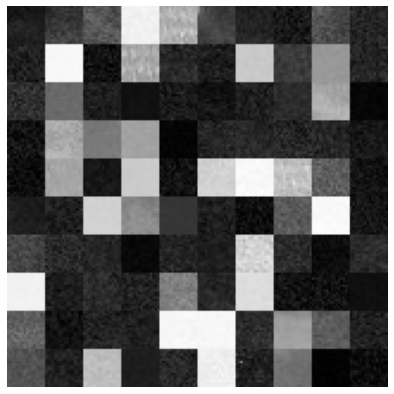

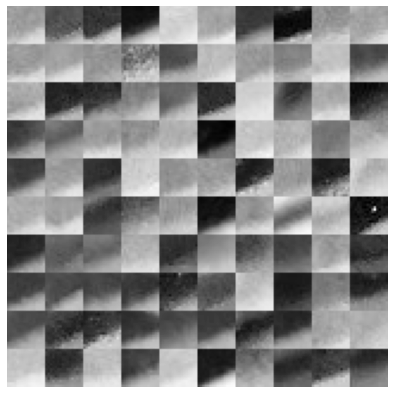

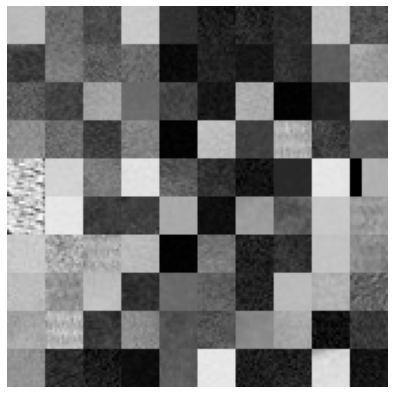

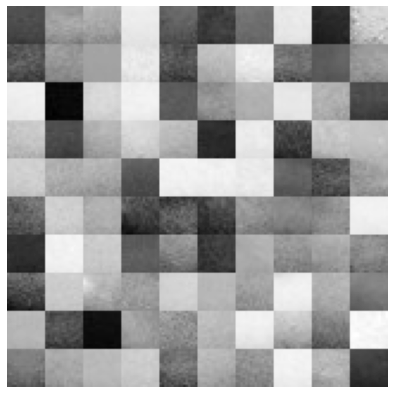

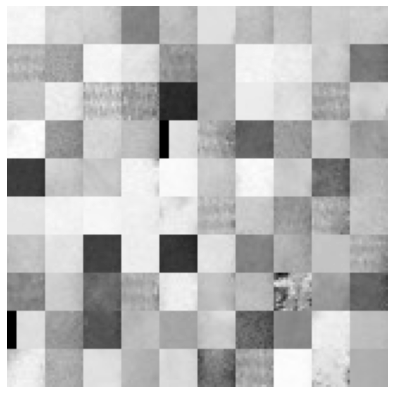

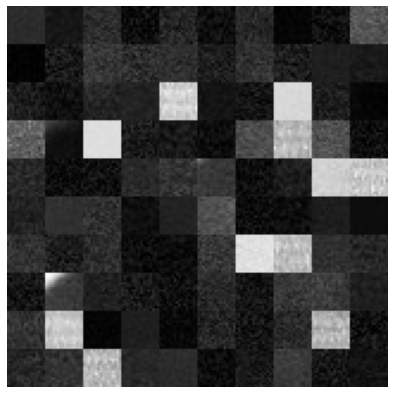

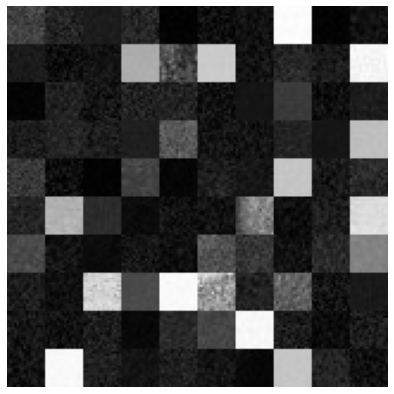

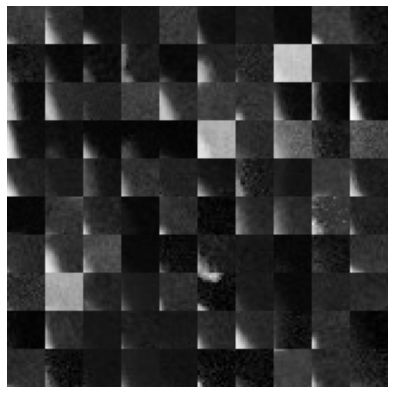

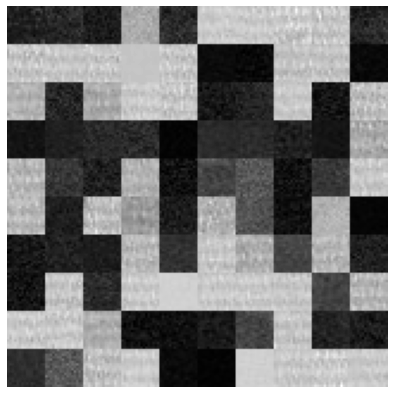

In [45]:
centers = list(range(20))
for center in centers:
  center_vect = vdict[center]
  dist = ((sift - center_vect)**2).sum(axis=1)
  # get best 100
  top100 = dist.argsort()[:100]
  top100_regions = regions[top100]
  display_images(top100_regions) # Show 100 random regions

# Bag of Features

In [48]:
def compute_feats(vdict, descriptors):
    """
    vdict: (num_clusters, 128): visual dictionnary containing all clusters.
    image_sifts: (H, W, 128) all sift features from the given image
    """
    # flatten sifts
    sifts = np.array(descriptors).reshape(-1, 128)  # (N, 128)
    #print(sifts.shape)
    feats = np.zeros(vdict.shape[0])
    
    distances = distance_matrix(sifts, vdict)
    best_feature = np.argmin(distances, axis=1)
    for i in best_feature:
      feats[i]+=1
    
    norm = np.linalg.norm(feats, ord=2)
    feats = feats/norm

    return feats

In [49]:
from numpy import asarray
from numpy import savez_compressed

In [52]:
idx = len(inames)

dataset_feats = []
for id in range(len(inames)):
    print(id)
    sift = descriptors[id]
    
    feats = compute_feats(vdict, sift)
    print(feats.shape)
    dataset_feats.append(feats)
    #display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here
savez_compressed('bow2.npz', dataset_feats) 

0
(1000,)
1
(1000,)
2
(1000,)
3
(1000,)
4
(1000,)
5
(1000,)
6
(1000,)
7
(1000,)
8
(1000,)
9
(1000,)
10
(1000,)
11
(1000,)
12
(1000,)
13
(1000,)
14
(1000,)
15
(1000,)
16
(1000,)
17
(1000,)
18
(1000,)
19
(1000,)
20
(1000,)
21
(1000,)
22
(1000,)
23
(1000,)
24
(1000,)
25
(1000,)
26
(1000,)
27
(1000,)
28
(1000,)
29
(1000,)
30
(1000,)
31
(1000,)
32
(1000,)
33
(1000,)
34
(1000,)
35
(1000,)
36
(1000,)
37
(1000,)
38
(1000,)
39
(1000,)
40
(1000,)
41
(1000,)
42
(1000,)
43
(1000,)
44
(1000,)
45
(1000,)
46
(1000,)
47
(1000,)
48
(1000,)
49
(1000,)
50
(1000,)
51
(1000,)
52
(1000,)
53
(1000,)
54
(1000,)
55
(1000,)
56
(1000,)
57
(1000,)
58
(1000,)
59
(1000,)
60
(1000,)
61
(1000,)
62
(1000,)
63
(1000,)
64
(1000,)
65
(1000,)
66
(1000,)
67
(1000,)
68
(1000,)
69
(1000,)
70
(1000,)
71
(1000,)
72
(1000,)
73
(1000,)
74
(1000,)
75
(1000,)
76
(1000,)
77
(1000,)
78
(1000,)
79
(1000,)
80
(1000,)
81
(1000,)
82
(1000,)
83
(1000,)
84
(1000,)
85
(1000,)
86
(1000,)
87
(1000,)
88
(1000,)
89
(1000,)
90
(1000,)
91
(1000,

In [53]:
dataX = np.array(dataset_feats)
dataY = ilabels

In [54]:
dataX.shape, dataY.shape

((280, 1000), (280,))

In [55]:
{c: nb for c, nb in enumerate(np.bincount(dataY))}

{0: 32, 1: 18, 2: 27, 3: 45, 4: 38, 5: 33, 6: 35, 7: 13, 8: 13, 9: 26}

In [6]:
data = np.load('bow2.npz')
dataX = np.array(data)
dataY = ilabels

In [9]:
dataX

array(['arr_0'], dtype='<U5')

In [7]:
test_ratio = 0.1
validation_ratio = 0.1

X_train_full, X_test, y_train_full, y_test = train_test_split(dataX, dataY, test_size=test_ratio, shuffle=True)

ValueError: Found input variables with inconsistent numbers of samples: [1, 280]

In [96]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_full, y_train_full, test_size=validation_ratio, shuffle=True)

In [99]:
model = SVC(C=50, kernel='sigmoid', max_iter=10000)
# Fit on sub-train set
# TODO
model.fit(X_train, y_train)
# Evaluate on val set
# TODO
y_hat_validation = model.predict(X_validation)
acc = accuracy_score(y_true=y_validation, y_pred=y_hat_validation)

In [100]:
print(f'--> accuracy = {acc}')

--> accuracy = 0.4230769230769231


In [103]:
y_hat_validation

array([9, 1, 0, 2, 3, 9, 3, 9, 0, 9, 3, 6, 4, 0, 0, 6, 2, 0, 1, 0, 4, 9,
       0, 6, 0, 5])

In [101]:
model = SVC()
distribution=dict(C=np.linspace(10, 100, 10),
                  kernel=['sigmoid','linear'], max_iter=[100,1000,10000],
                  gamma=['scale', 'auto'],
                  class_weight=[None, 'balanced'],
                  decision_function_shape=['ovo', 'ovr']
                  )
clf = RandomizedSearchCV(model, distribution, n_jobs=-1, verbose=1)
search = clf.fit(X_train_full, y_train_full)
search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\94\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'max_iter': 100,
 'kernel': 'linear',
 'gamma': 'scale',
 'decision_function_shape': 'ovo',
 'class_weight': None,
 'C': 60.0}

In [102]:
clf.best_score_

0.507764705882353